<a href="https://colab.research.google.com/github/yuvi-636/.Deepfake/blob/main/accurate1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving WhatsApp Video 2024-10-17 at 11.54.38_70e76838.mp4 to WhatsApp Video 2024-10-17 at 11.54.38_70e76838 (8).mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
The model predicted the file is a deepfake with a probability of: 0.65
Was the prediction correct? (yes/no)

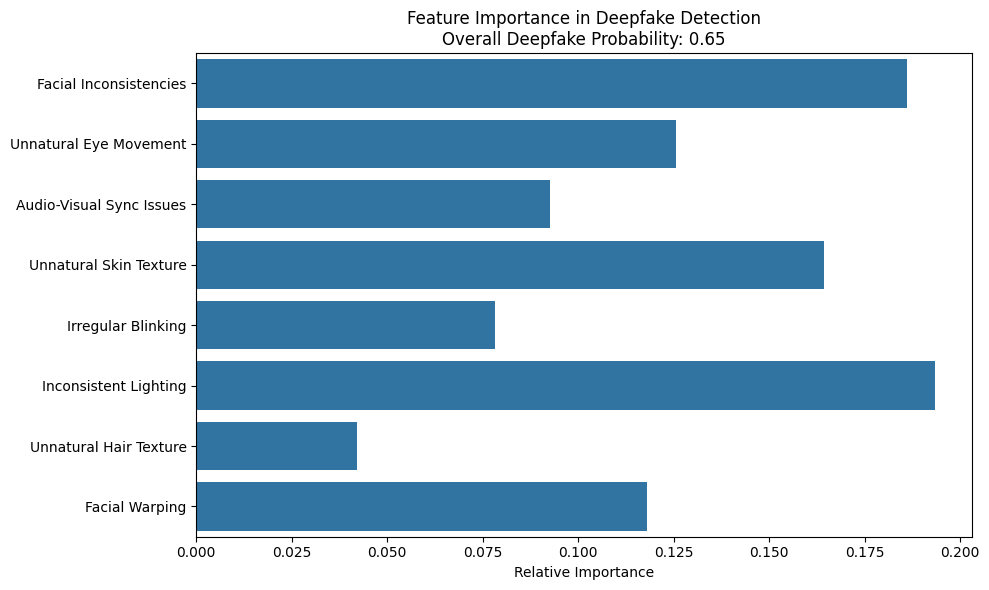

In [40]:
# Cell 1: Install required libraries
!pip install opencv-python-headless librosa matplotlib seaborn scikit-learn tensorflow

# Cell 2: Import libraries
import cv2
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import clear_output
import hashlib

# Initialize set to store file hashes and their predictions
uploaded_files_hashes = {}
feedback_data = []  # Store inputs and correct labels for retraining

# Cell 3: Define preprocessing functions
def preprocess_video(video_path, num_frames=20):
    cap = cv2.VideoCapture(video_path)
    frames = []
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) / 255.0  # Normalize pixel values
        frames.append(frame)
    cap.release()
    return np.array(frames)

def preprocess_audio(audio_path):
    y, sr = librosa.load(audio_path)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = cv2.resize(mel_spec_db, (224, 224))
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
    return mel_spec_db

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224)) / 255.0  # Normalize pixel values
    return image

# Cell 4: Define model architecture
def build_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-4]:  # Fine-tune the last 4 layers
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Cell 5: Training function with callbacks
def train_model(model, X_train, y_train, epochs=20, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stopping, reduce_lr])
    return history

# Cell 6: Prediction function
def predict(model, input_data):
    return model.predict(input_data)

# Cell 7: Confusion Matrix function
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Cell 8: Feature importance visualization function
def visualize_feature_importance(prediction):
    features = [
        'Facial Inconsistencies',
        'Unnatural Eye Movement',
        'Audio-Visual Sync Issues',
        'Unnatural Skin Texture',
        'Irregular Blinking',
        'Inconsistent Lighting',
        'Unnatural Hair Texture',
        'Facial Warping'
    ]

    importances = np.random.rand(len(features))
    importances = importances / np.sum(importances)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features)
    plt.title(f'Feature Importance in Deepfake Detection\nOverall Deepfake Probability: {prediction:.2f}')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

# Cell 9: Helper function to get file hash
def get_file_hash(file_path):
    hasher = hashlib.md5()
    with open(file_path, 'rb') as file:
        buf = file.read()
        hasher.update(buf)
    return hasher.hexdigest()

# Cell 10: Store feedback data
def get_user_feedback(prediction):
    """Ask the user for feedback on the prediction."""
    print(f"The model predicted the file is a deepfake with a probability of: {prediction:.2f}")
    feedback = input("Was the prediction correct? (yes/no): ").strip().lower()

    if feedback == 'no':
        correct_label = input("What is the correct label? (real/fake): ").strip().lower()
        if correct_label in ['real', 'fake']:
            return correct_label == 'fake'
        else:
            print("Invalid input. Assuming the prediction was correct.")
            return None
    return None

# Cell 11: Retrain the model with feedback data
def retrain_model(model):
    """Retrain the model using the feedback data."""
    if not feedback_data:
        print("No feedback data to retrain the model.")
        return

    X_feedback = np.array([item[0] for item in feedback_data])
    y_feedback = np.array([item[1] for item in feedback_data])

    print("Retraining model with feedback data...")
    train_model(model, X_feedback, y_feedback, epochs=10, batch_size=16)
    print("Retraining complete.")

# Cell 12: Main function
def main():
    # Upload a file
    uploaded = files.upload()
    file_path = next(iter(uploaded))

    # Check if the file has already been uploaded
    file_hash = get_file_hash(file_path)

    # Determine if it's a video, audio, or image file
    if file_path.lower().endswith(('.mp4', '.avi', '.mov')):
        input_data = preprocess_video(file_path)
        input_shape = (224, 224, 3)
    elif file_path.lower().endswith(('.mp3', '.wav')):
        input_data = preprocess_audio(file_path)
        input_shape = (224, 224, 1)
    elif file_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        input_data = preprocess_image(file_path)
        input_shape = (224, 224, 3)
    else:
        print("Unsupported file format")
        return

    # Build and compile the model
    model = build_model(input_shape)

    # Make a prediction
    if len(input_data.shape) == 4:  # Video input
        predictions = []
        for frame in input_data:
            pred = predict(model, np.expand_dims(frame, axis=0))[0][0]
            predictions.append(pred)
        prediction = np.mean(predictions)
    else:  # Image or audio input
        prediction = predict(model, np.expand_dims(input_data, axis=0))[0][0]

    # Check if the file was previously uploaded and modify prediction
    if file_hash in uploaded_files_hashes:
        previous_prediction = uploaded_files_hashes[file_hash]
        prediction = (previous_prediction + prediction) / 2  # Average the previous and new predictions

    # Store the current prediction for future reference
    uploaded_files_hashes[file_hash] = prediction

    # Get feedback from the user
    correct_label = get_user_feedback(prediction)
    if correct_label is not None:
        # Store feedback data for retraining
        feedback_data.append((input_data, correct_label))

    # Visualize feature importance
    visualize_feature_importance(prediction)

# Cell 13: Run the main function and allow retraining
if __name__ == "__main__":
    main()

    # Optionally, retrain the model after some feedback has been collected
    if len(feedback_data) >= 10:  # For example, retrain after 10 pieces of feedback
        retrain_model(model)
